# Look at result of multi-k val run for decay-val =1

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from stabnode.utils import set_global_seed

plt.style.use("ggplot")

device = 'cpu'
set_global_seed(1234)

In [2]:
log_path = "decay_1/log_hist.pkl"

In [3]:
with open(log_path, 'rb') as file:
    log = pickle.load(file)

In [4]:
log.keys()

dict_keys(['losses', 'times', 'stopping_criteria', 'best_model_epoch', 'method_status', 'patience_hist', 'lr_hist'])

In [5]:
log["stopping_criteria"]

'early-stoppage'

In [6]:
np.sum(log["times"]) / 60 /60

21.173768746852875

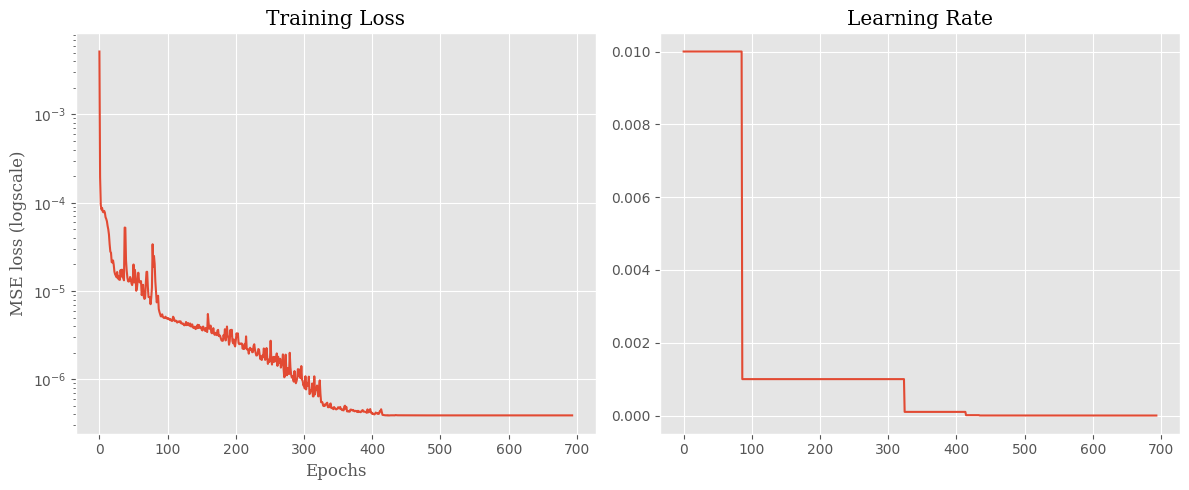

In [50]:
fam = 'serif'
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(log["losses"])
ax1.set_yscale("log")
ax1.set_title("Training Loss", family=fam)
ax1.set_xlabel("Epochs", family=fam)
ax1.set_ylabel("MSE loss (logscale)", family=fam)
ax2.plot(log['lr_hist'])
ax2.set_title("Learning Rate", family=fam)
plt.tight_layout()
plt.show()

# load model

In [8]:
from stabnode.node import FeluSigmoidMLP, GeluSigmoidMLPfeaturized, StabNODE

In [9]:
model_path = "decay_1/model_opt_states.pt"

In [10]:
config = torch.load(model_path, map_location='cpu', weights_only=False)

In [11]:
config.keys()

dict_keys(['f_state_dict', 'g_state_dict', 'stabnode_state_dict', 'f_args', 'g_args', 'opt_state_dict', 'epoch', 'loss', 'scheduler_state_dict'])

In [12]:
f = FeluSigmoidMLP(
    dims=[1, 10, 10, 1],
    activation=nn.SiLU(),
    lower_bound=-0.5,
    upper_bound=-0.1,
)

g = GeluSigmoidMLPfeaturized(
    dims=[6, 10, 10, 1],
    activation=nn.SiLU(),
    lower_bound=-5,
    upper_bound=1.1,
    freq_sample_step=1,
    feat_lower_bound=0,
    feat_upper_bound=1,
)

model = StabNODE(f,g)

f.load_state_dict(config["f_state_dict"])
g.load_state_dict(config["g_state_dict"])
model.load_state_dict(config["stabnode_state_dict"])
model.to(device)

StabNODE(
  (f): FeluSigmoidMLP(
    (activation): SiLU()
    (network): MLP(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
  (g): GeluSigmoidMLPfeaturized(
    (activation): SiLU()
    (network): MLP(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Linear(in_features=6, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
)

## Load data 

In [13]:
from sklearn.preprocessing import MinMaxScaler
from data.budworm import simulate_trials
import pandas as pd

In [14]:
from typing import List
class TrialsDataset(torch.utils.data.Dataset):
    def __init__(self, x_trials: List, t_trials: List, k_trials: List):
        self.x_trials = x_trials
        self.t_trials = t_trials
        self.k_trials = k_trials

    def __len__(self):
        return len(self.x_trials)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self):
            raise IndexError(
                f"Index {idx} is out of bounds of dataset size: {len(self)}."
            )

        Xi = self.x_trials[idx]
        ti = self.t_trials[idx]
        x0 = Xi[0]
        ki = self.k_trials[idx]

        return Xi, ti, x0, ki

In [15]:
# Simulation parameters
k_vals = [5.5, 6.3, 7.5, 8.5, 11.0]  # carrying capacities
xs = np.linspace(0.1, 10, 51)

# -----------------------------------------------------------------
# DATA GENERATION
# -----------------------------------------------------------------
trials = {}
for idx, ki in enumerate(k_vals):
    ki_traj, ki_times = [], []

    for x0 in xs:
        trial = simulate_trials(
            [ki],
            x0,
            dt=0.2,
            r=0.56,
            eps=1e-3,
            buffer=1e-1,
            t_max=400,
            n_points=501,
            show_progress=False,
        )
        if len(trial.t_vals[0]) == 1:
            continue
        ki_traj.append(trial.x_vals[0])
        ki_times.append(trial.t_vals[0])

    trials[str(idx)] = {
        "traj": ki_traj,
        "times": ki_times,
        "k": ki,
        "trial": idx,
    }

trial_df = pd.DataFrame(trials)

# -----------------------------------------------------------------
# SCALING
# -----------------------------------------------------------------
full_traj = [np.concatenate(trial_df[col].traj) for col in trial_df.columns]
scaler = MinMaxScaler()
scaler.fit(np.concatenate(full_traj).reshape(-1, 1))

scaled_rows = {}
for col in trial_df.columns:
    traj = trial_df[col].traj
    scaled_rows[col] = [
        scaler.transform(xi.reshape(-1, 1)).reshape(-1) for xi in traj
    ]
trial_df.loc["scaled_traj"] = pd.Series(scaled_rows)

# -----------------------------------------------------------------
# TORCH DATASET PREP
# -----------------------------------------------------------------
all_xs, all_ts, all_ks = [], [], []

for trial_i in trial_df.columns:
    xs_scaled = trial_df[trial_i].scaled_traj
    ts = trial_df[trial_i].times
    k = trial_df[trial_i].k

    xs_torch = [
        torch.tensor(xi, dtype=torch.float32, device=device) for xi in xs_scaled
    ]
    ts_torch = [
        torch.tensor(ti, dtype=torch.float32, device=device) for ti in ts
    ]
    ks = [torch.tensor(k, dtype=torch.float32, device=device) for _ in ts]

    all_xs.extend(xs_torch)
    all_ts.extend(ts_torch)
    all_ks.extend(ks)

train_dataset = TrialsDataset(all_xs, all_ts, all_ks)

In [16]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=1, num_workers=0
)

In [17]:
count = 0
for out in train_loader:
    if count == 0:
        xi,ti,x0i, ki = out
    count = 1

In [18]:
ki.shape, train_dataset[0][-1].view(1).shape

(torch.Size([1]), torch.Size([1]))

In [19]:
len(train_dataset)

254

In [20]:
*_, ki = train_dataset[50]
ki

tensor(5.5000)

In [21]:
ki.shape

torch.Size([])

In [22]:
255/5

51.0

## True g and f

In [23]:
from data.budworm import g_true, f_true

In [24]:
f_eval  = f.eval()
g_eval = g.eval()
model_eval = StabNODE(f_eval, g_eval)
model_eval.eval()

StabNODE(
  (f): FeluSigmoidMLP(
    (activation): SiLU()
    (network): MLP(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
  (g): GeluSigmoidMLPfeaturized(
    (activation): SiLU()
    (network): MLP(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Linear(in_features=6, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
)

In [25]:
x_lin = np.linspace(0,1,101)
g_preds = []
with torch.no_grad():
    x_lin_torch = torch.tensor(x_lin, dtype=torch.float32)
    f_pred = [f_eval(xi.reshape(-1,1)).reshape(-1) for xi in x_lin_torch]
    f_pred = torch.cat(f_pred)
    
    for k in k_vals:
        k_torch = torch.tensor(k,dtype=torch.float32).reshape(-1,1)
        g_pred =torch.cat([g_eval(torch.tensor([[xi]],dtype=torch.float32),k_torch).reshape(-1) for xi in x_lin_torch])
        g_preds.append(g_pred)

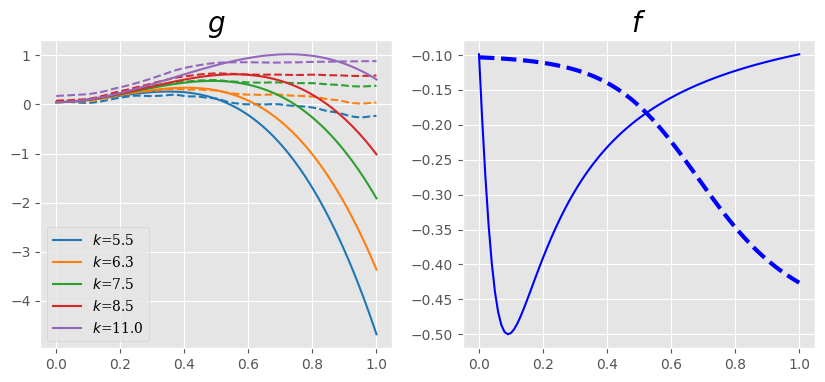

(1.0227762788018373, -4.684481175390267)

In [48]:
colors = list(plt.cm.tab10.colors)

x_lin = np.linspace(0,1,101)
x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).squeeze()

fig , (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
maxs = []
mins = []
for idx, k in enumerate(k_vals):
    g_true_arr = scaler.transform(g_true(x_lin_unscaled,k,r=0.56).reshape(-1,1)).reshape(-1)
    maxs.append(g_true_arr.max())
    mins.append(g_true_arr.min())

    ax1.plot(x_lin, g_true_arr, label=rf"$k$={k}",c=colors[idx])
    ax1.plot(x_lin, g_preds[idx],linestyle='--', c=colors[idx])

ax1.legend(prop={'family':'serif'})

f_true_arr = f_true(x_lin_unscaled)
ax1.set_title(r"$g$",size=20)
ax2.set_title(r"$f$",size=20)
ax2.plot(x_lin, f_true_arr,c='blue')
ax2.plot(x_lin, f_pred,linestyle="--",lw=3,c='blue')
plt.show()

max(maxs), min(mins)

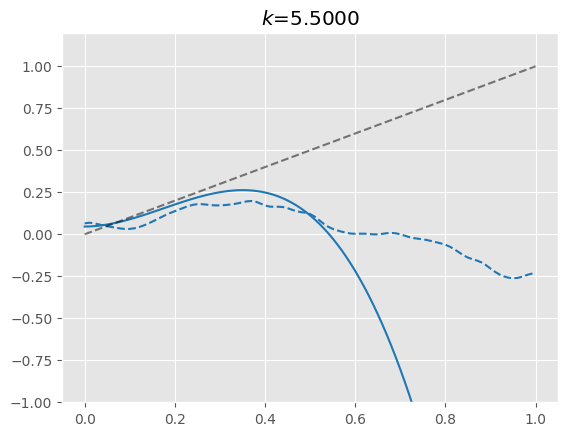

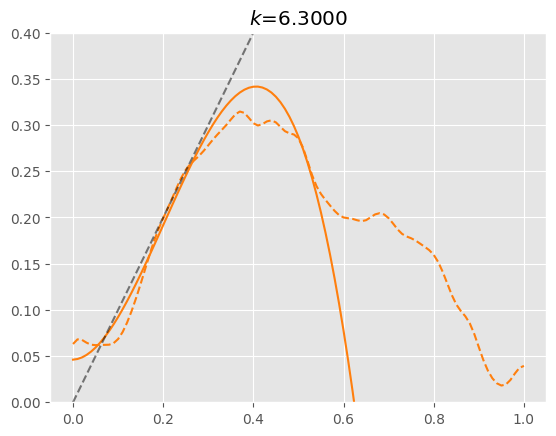

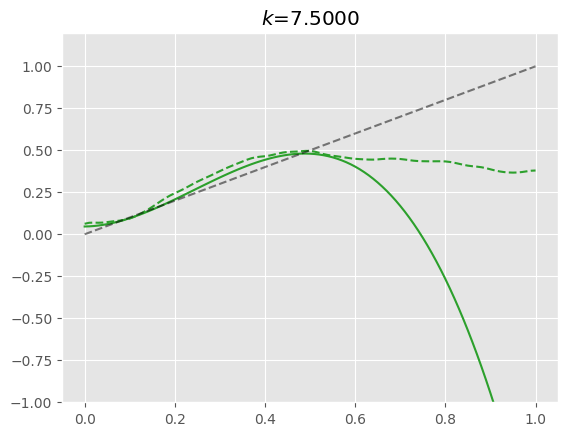

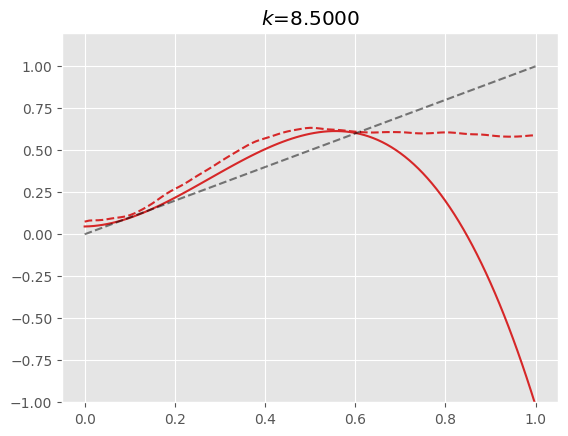

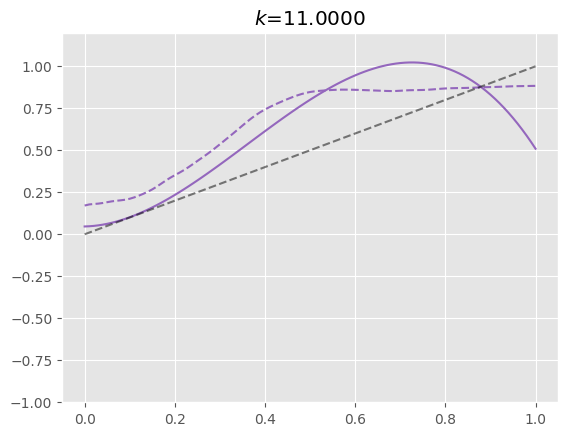

In [28]:
for idx, k in enumerate(k_vals):
    g_true_arr = scaler.transform(g_true(x_lin_unscaled,k,r=0.56).reshape(-1,1)).reshape(-1)
    plt.title(rf"$k$={k:.4f}")
    plt.plot(x_lin, g_true_arr, label=rf"$k$={k}",c=colors[idx])
    plt.plot(x_lin, g_preds[idx],linestyle='--', c=colors[idx])
    plt.plot(x_lin,x_lin, linestyle='--', c='black', alpha=0.5)
    if idx == 1:
        plt.ylim(0,0.4)
    else:
        plt.ylim(-1,1.2)
    plt.show()

## Plotting trajectories

In [29]:
from torchode import solve_ivp
from tqdm.auto import tqdm
from data.budworm import budworm_steady_states

In [30]:
# 0-50
# 51 - 101
# 102 - 151
# 152
indices = [0]
for key, val in trials.items():
    print(val["k"], len(val["traj"]))
    indices.append(len(val["traj"]))


5.5 51
6.3 51
7.5 50
8.5 51
11.0 51


In [31]:
indices = np.cumsum(indices)

In [32]:
# for i in range(indices[0], indices[1]):
#     print(i)

  0%|          | 0/51 [00:00<?, ?it/s]

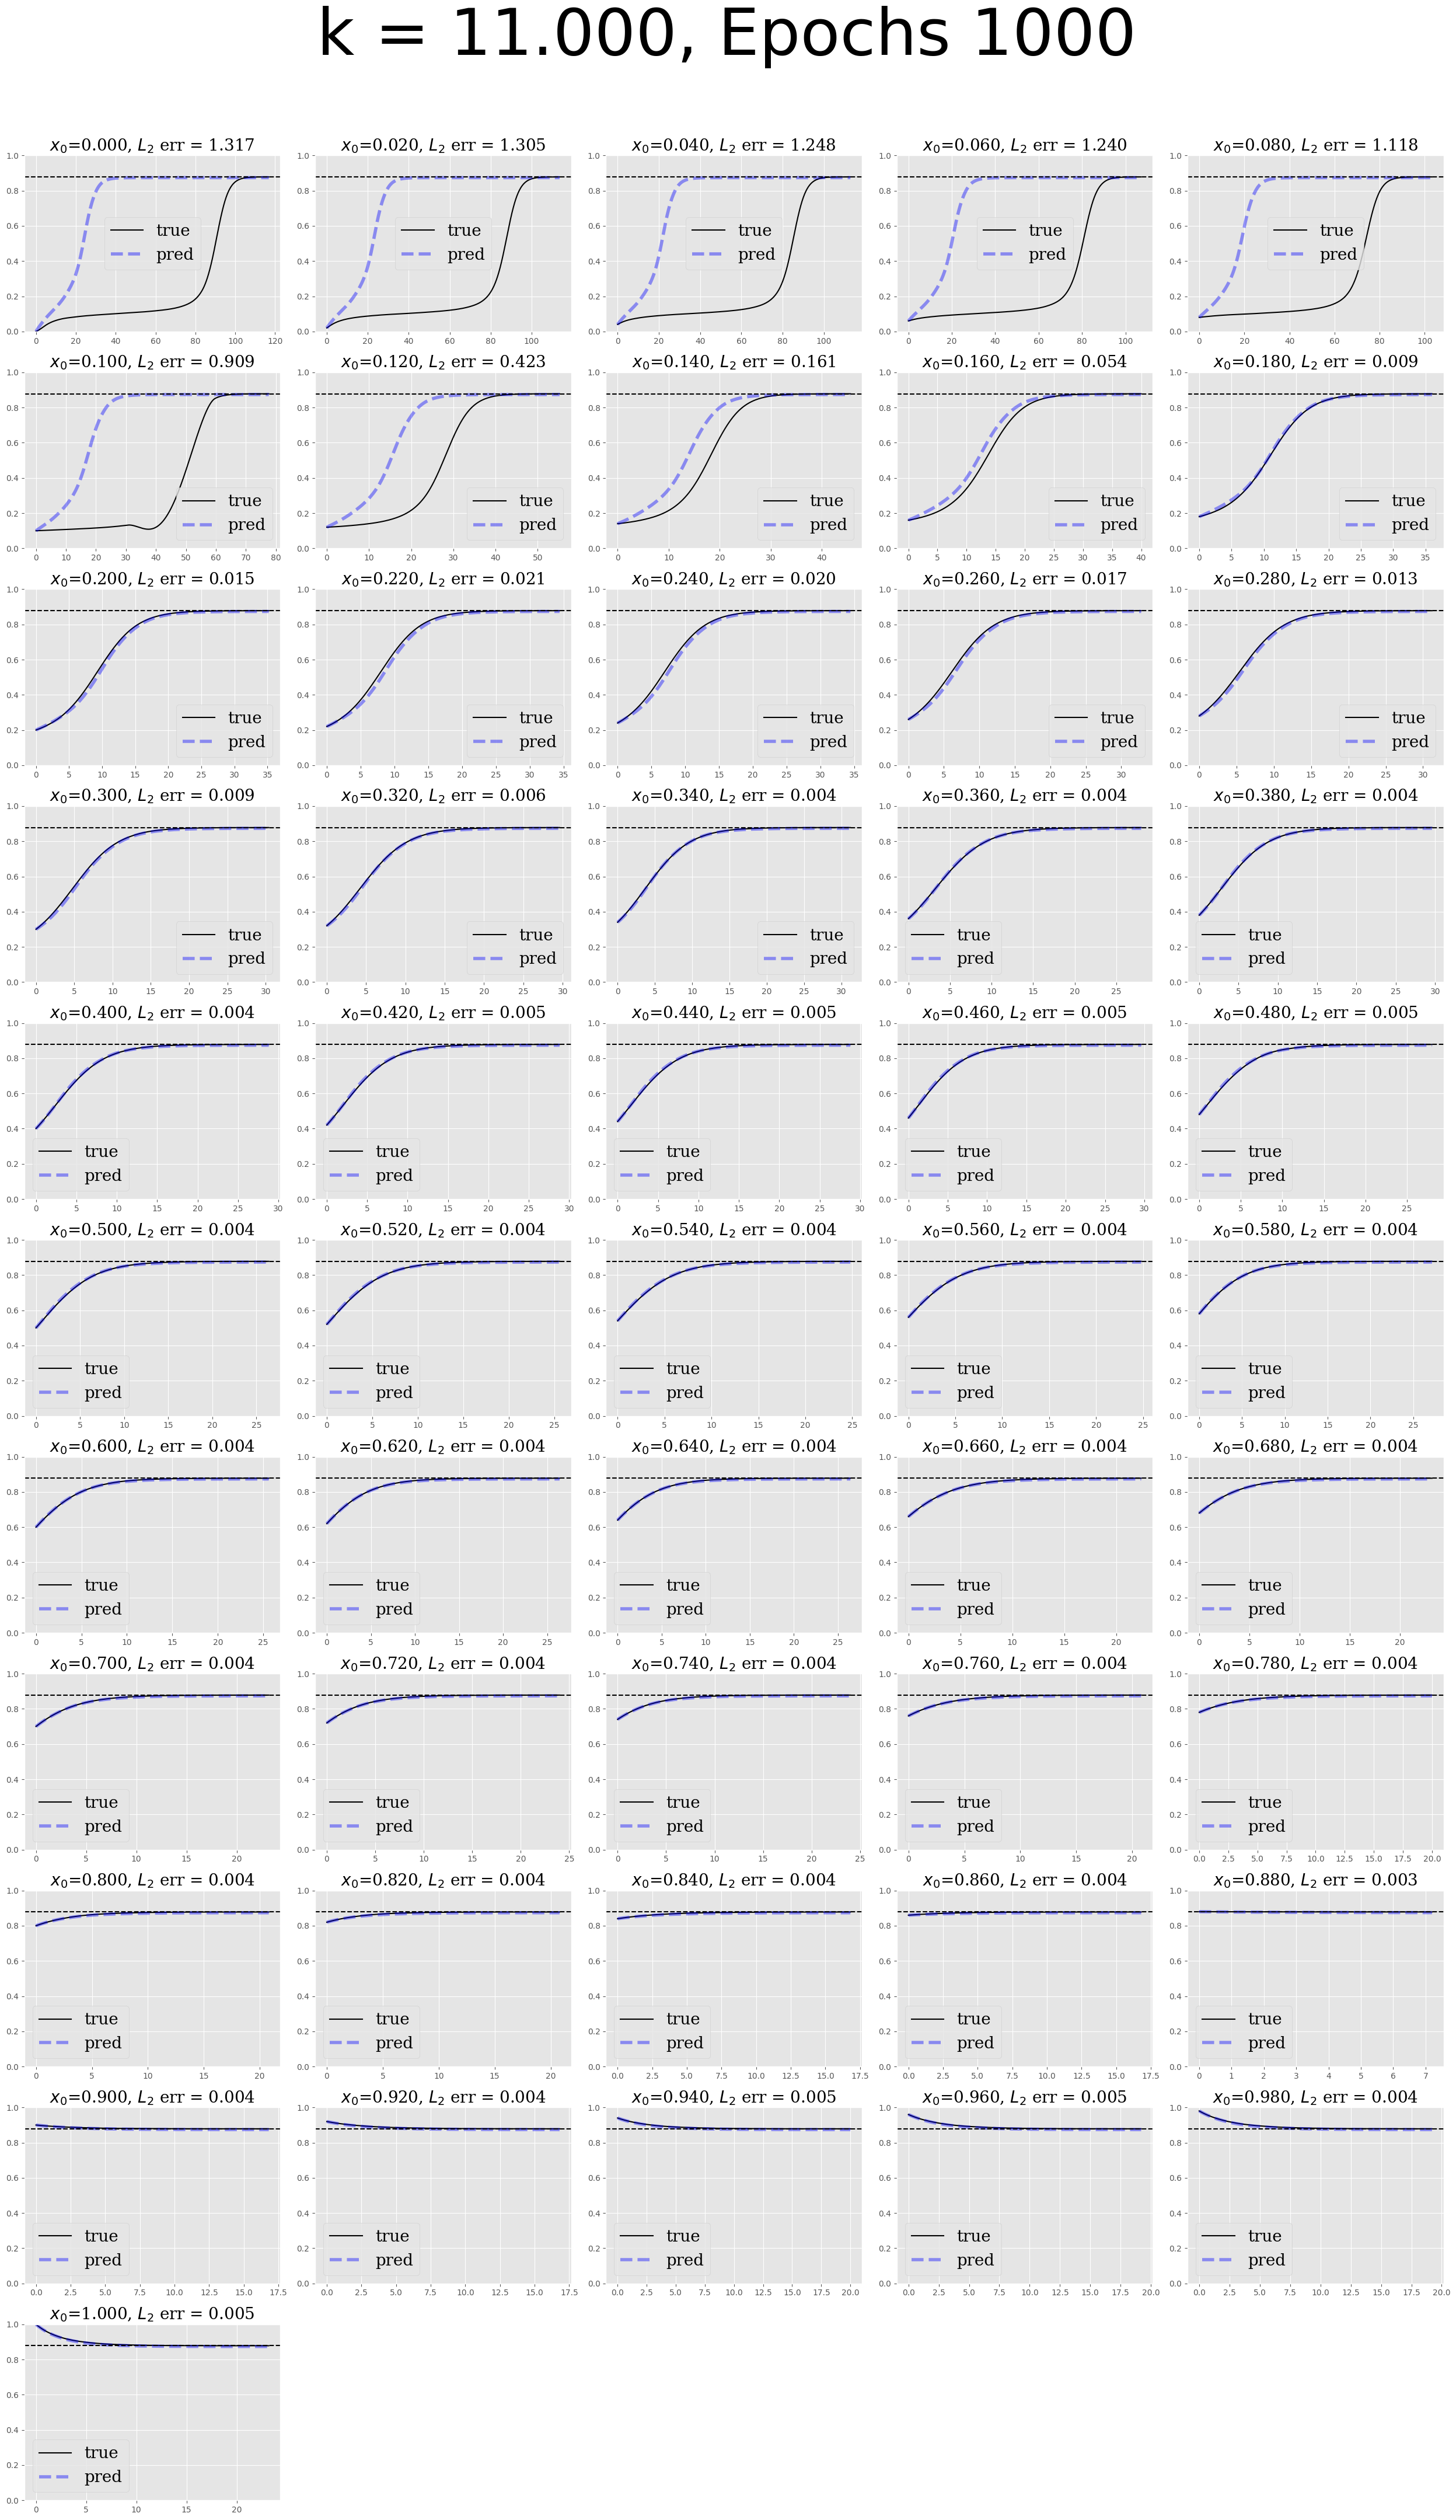

In [45]:
i=4
cols = 5
rows = int(np.ceil(len(range(indices[i], indices[i+1]))/cols))

fig, axs = plt.subplots(rows, cols,figsize=(5*cols,4*rows))

axs = axs.flatten()
k_val = None
# control_func = lambda t: torch.tensor(k,dtype=torch.float32,device=device).unsqueeze(0)
with torch.no_grad():
    for idx in tqdm(range(indices[i], indices[i+1])):
        ax = axs[idx - indices[i]]
        xi, ti, x0i,ki = train_dataset[idx]
        xi = xi.squeeze() # [batch, time, dim]
        ti = ti.squeeze()
        k_val = ki
        ki = ki.view(1)
        x0i = x0i.view(-1,1)

        # print(xi.shape, ti.shape)

        control_func = lambda t: ki
        sol = solve_ivp(
            f=lambda t, x: model_eval(t, x, control_func),
            y0=x0i,
            t_eval=ti,
            method="tsit5"
        )

        rel_l2_err = np.linalg.norm(sol.ys.squeeze() - xi)/np.linalg.norm(xi)

        ax.plot(ti,xi,label='true',color='black')
        ax.plot(sol.ts.squeeze(),sol.ys.squeeze(),label="pred", linestyle='--', color='blue',alpha=0.4,lw=4)
        ax.set_ylim(0,1)
        ax.set_title(rf"$x_0$={x0i.squeeze().cpu().numpy():.3f}, $L_2$ err = {rel_l2_err:.3f}", family='serif',size=20)
        ax.legend(prop={'family':'serif','size':20})

        scaled_steady_states = scaler.transform(np.array(budworm_steady_states(ki.squeeze(),r=0.56)).reshape(-1,1)).reshape(-1)
        for idx,xsi in enumerate(scaled_steady_states):
            label = rf"steady state. $x_s=${xsi:.3f}"
            color = 'black'
            if idx ==1:
                label = rf"unsteady state. $x_s=${xsi:.3f}"
                color = 'red'

            ax.axhline(
                xsi,
                xmin=0,
                c=color,
                linestyle="--",
                label=label,
                zorder=2
            )

    for idx in range(len(range(indices[i], indices[i+1])), rows*cols):
        fig.delaxes(axs[idx])

plt.suptitle(f"k = {k_val.squeeze().numpy():.3f}, Epochs {1000}", size=80)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


## decay_val = 0.8

In [4]:
log_path = "decay_08/log_hist.pkl"

with open(log_path, 'rb') as file:
    log = pickle.load(file)

In [5]:
log.keys()

dict_keys(['losses', 'times', 'stopping_criteria', 'best_model_epoch', 'method_status', 'patience_hist', 'lr_hist'])

In [6]:
log["stopping_criteria"]

'early-stoppage'

In [7]:
np.sum(log["times"]) / 60 /60

18.657327311502563

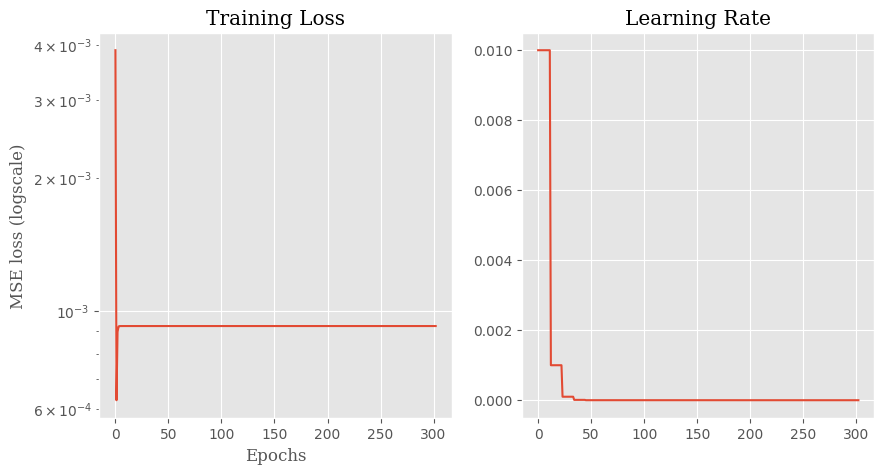

In [10]:
fam = 'serif'
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(log["losses"])
ax1.set_yscale("log")
ax1.set_title("Training Loss", family=fam)
ax1.set_xlabel("Epochs", family=fam)
ax1.set_ylabel("MSE loss (logscale)", family=fam)
ax2.plot(log['lr_hist'])
ax2.set_title("Learning Rate", family=fam)
plt.show()

## Load model

In [11]:
from stabnode.node import FeluSigmoidMLP, GeluSigmoidMLPfeaturized, StabNODE

In [13]:
model_path = "decay_08/model_opt_states.pt"

In [14]:
config = torch.load(model_path, map_location='cpu', weights_only=False)

In [15]:
f = FeluSigmoidMLP(
    dims=[1, 10, 10, 1],
    activation=nn.SiLU(),
    lower_bound=-0.5,
    upper_bound=-0.1,
)

g = GeluSigmoidMLPfeaturized(
    dims=[6, 10, 10, 1],
    activation=nn.SiLU(),
    lower_bound=-5,
    upper_bound=1.1,
    freq_sample_step=1,
    feat_lower_bound=0,
    feat_upper_bound=1,
)

model = StabNODE(f,g)

f.load_state_dict(config["f_state_dict"])
g.load_state_dict(config["g_state_dict"])
model.load_state_dict(config["stabnode_state_dict"])
model.to(device)

StabNODE(
  (f): FeluSigmoidMLP(
    (activation): SiLU()
    (network): MLP(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
  (g): GeluSigmoidMLPfeaturized(
    (activation): SiLU()
    (network): MLP(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Linear(in_features=6, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
)

## Load data

In [16]:
from sklearn.preprocessing import MinMaxScaler
from data.budworm import simulate_trials
import pandas as pd

In [18]:
# Simulation parameters
k_vals = [5.5, 6.3, 7.5, 8.5, 11.0]  # carrying capacities
xs = np.linspace(0.1, 10, 51)

# -----------------------------------------------------------------
# DATA GENERATION
# -----------------------------------------------------------------
trials = {}
for idx, ki in enumerate(k_vals):
    ki_traj, ki_times = [], []

    for x0 in xs:
        trial = simulate_trials(
            [ki],
            x0,
            dt=0.2,
            r=0.56,
            eps=1e-3,
            buffer=1e-1,
            t_max=400,
            n_points=501,
            show_progress=False,
        )
        if len(trial.t_vals[0]) == 1:
            continue
        ki_traj.append(trial.x_vals[0])
        ki_times.append(trial.t_vals[0])

    trials[str(idx)] = {
        "traj": ki_traj,
        "times": ki_times,
        "k": ki,
        "trial": idx,
    }

trial_df = pd.DataFrame(trials)

# -----------------------------------------------------------------
# SCALING
# -----------------------------------------------------------------
full_traj = [np.concatenate(trial_df[col].traj) for col in trial_df.columns]
scaler = MinMaxScaler()
scaler.fit(np.concatenate(full_traj).reshape(-1, 1))

scaled_rows = {}
for col in trial_df.columns:
    traj = trial_df[col].traj
    scaled_rows[col] = [
        scaler.transform(xi.reshape(-1, 1)).reshape(-1) for xi in traj
    ]
trial_df.loc["scaled_traj"] = pd.Series(scaled_rows)

# -----------------------------------------------------------------
# TORCH DATASET PREP
# -----------------------------------------------------------------
all_xs, all_ts, all_ks = [], [], []

for trial_i in trial_df.columns:
    xs_scaled = trial_df[trial_i].scaled_traj
    ts = trial_df[trial_i].times
    k = trial_df[trial_i].k

    xs_torch = [
        torch.tensor(xi, dtype=torch.float32, device=device) for xi in xs_scaled
    ]
    ts_torch = [
        torch.tensor(ti, dtype=torch.float32, device=device) for ti in ts
    ]
    ks = [torch.tensor(k, dtype=torch.float32, device=device) for _ in ts]

    all_xs.extend(xs_torch)
    all_ts.extend(ts_torch)
    all_ks.extend(ks)

train_dataset = TrialsDataset(all_xs, all_ts, all_ks)

## $g$ and $f$

In [19]:
from data.budworm import g_true, f_true

In [20]:
f_eval  = f.eval()
g_eval = g.eval()

In [21]:
x_lin = np.linspace(0,1,101)
g_preds = []
with torch.no_grad():
    x_lin_torch = torch.tensor(x_lin, dtype=torch.float32)
    f_pred = [f_eval(xi.reshape(-1,1)).reshape(-1) for xi in x_lin_torch]
    f_pred = torch.cat(f_pred)
    
    for k in k_vals:
        k_torch = torch.tensor(k,dtype=torch.float32).reshape(-1,1)
        g_pred =torch.cat([g_eval(torch.tensor([[xi]],dtype=torch.float32),k_torch).reshape(-1) for xi in x_lin_torch])
        g_preds.append(g_pred)

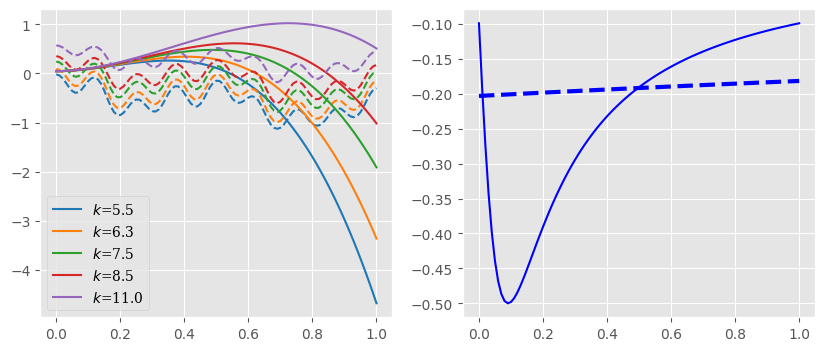

(1.0227762788018373, -4.684481175390267)

In [22]:
colors = list(plt.cm.tab10.colors)

x_lin = np.linspace(0,1,101)
x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).squeeze()

fig , (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
maxs = []
mins = []
for idx, k in enumerate(k_vals):
    g_true_arr = scaler.transform(g_true(x_lin_unscaled,k,r=0.56).reshape(-1,1)).reshape(-1)
    maxs.append(g_true_arr.max())
    mins.append(g_true_arr.min())

    ax1.plot(x_lin, g_true_arr, label=rf"$k$={k}",c=colors[idx])
    ax1.plot(x_lin, g_preds[idx],linestyle='--', c=colors[idx])

ax1.legend(prop={'family':'serif'})

f_true_arr = f_true(x_lin_unscaled)
ax2.plot(x_lin, f_true_arr,c='blue')
ax2.plot(x_lin, f_pred,linestyle="--",lw=3,c='blue')
plt.show()

max(maxs), min(mins)

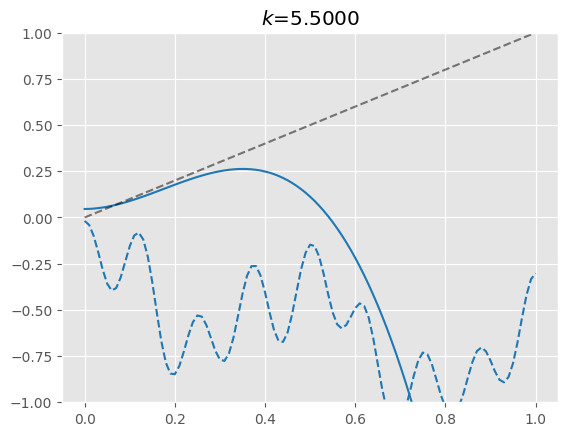

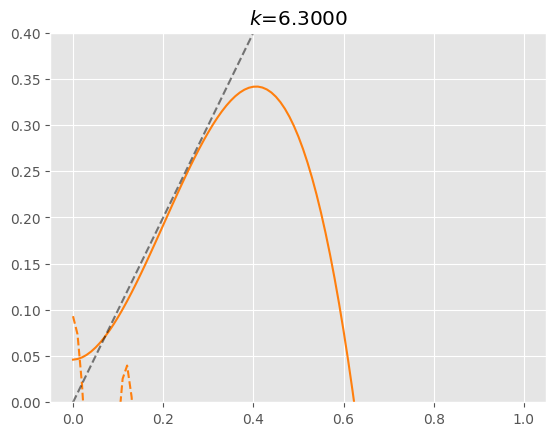

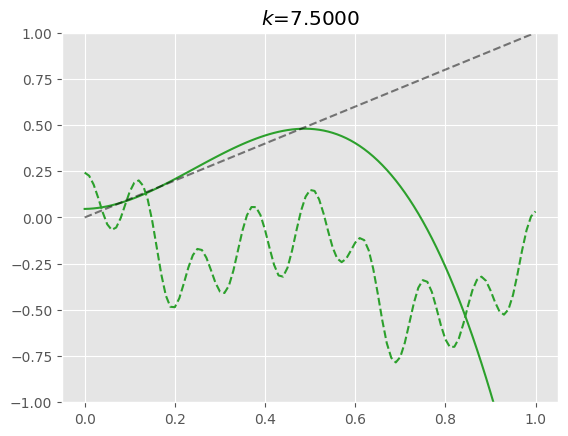

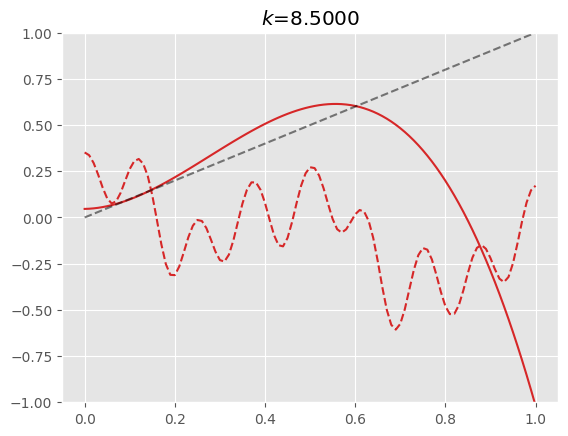

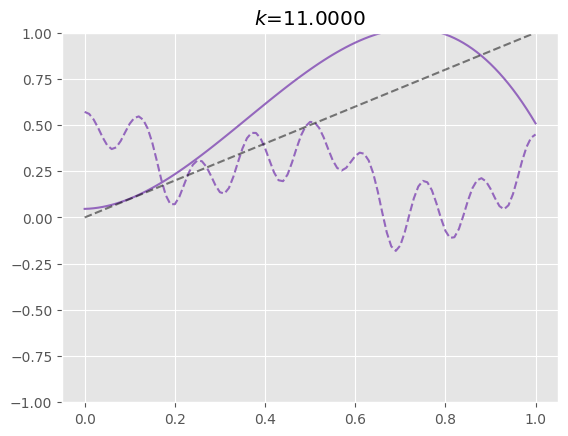

In [23]:
for idx, k in enumerate(k_vals):
    g_true_arr = scaler.transform(g_true(x_lin_unscaled,k,r=0.56).reshape(-1,1)).reshape(-1)
    plt.title(rf"$k$={k:.4f}")
    plt.plot(x_lin, g_true_arr, label=rf"$k$={k}",c=colors[idx])
    plt.plot(x_lin, g_preds[idx],linestyle='--', c=colors[idx])
    plt.plot(x_lin,x_lin, linestyle='--', c='black', alpha=0.5)
    if idx == 1:
        plt.ylim(0,0.4)
    else:
        plt.ylim(-1,1)
    plt.show()

## Decay_val = 0.5

In [24]:
log_path = "decay_05/log_hist.pkl"

with open(log_path, 'rb') as file:
    log = pickle.load(file)

In [25]:
log.keys()

dict_keys(['losses', 'times', 'stopping_criteria', 'best_model_epoch', 'method_status', 'patience_hist', 'lr_hist'])

In [27]:
np.sum(log["times"]) / 60 /60

17.24970857302348

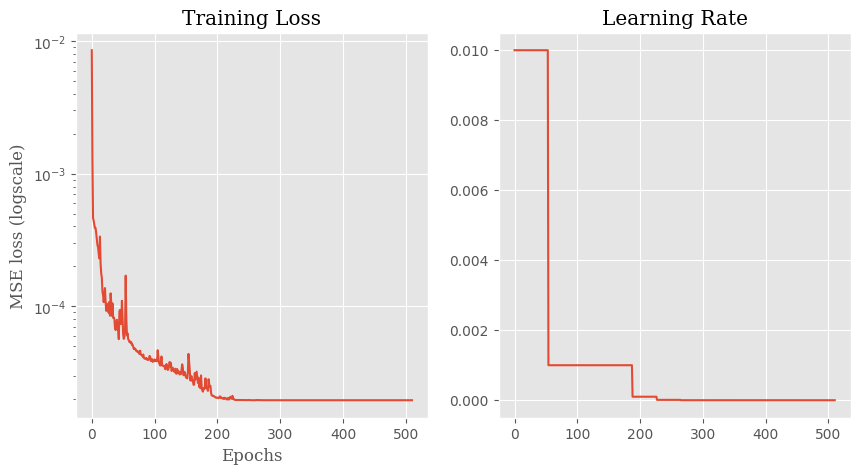

In [26]:
fam = 'serif'
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(log["losses"])
ax1.set_yscale("log")
ax1.set_title("Training Loss", family=fam)
ax1.set_xlabel("Epochs", family=fam)
ax1.set_ylabel("MSE loss (logscale)", family=fam)
ax2.plot(log['lr_hist'])
ax2.set_title("Learning Rate", family=fam)
plt.show()

# Load model

In [28]:
from stabnode.node import FeluSigmoidMLP, GeluSigmoidMLPfeaturized, StabNODE

In [29]:
# Simulation parameters
k_vals = [5.5, 6.3, 7.5, 8.5, 11.0]  # carrying capacities
xs = np.linspace(0.1, 10, 51)

# -----------------------------------------------------------------
# DATA GENERATION
# -----------------------------------------------------------------
trials = {}
for idx, ki in enumerate(k_vals):
    ki_traj, ki_times = [], []

    for x0 in xs:
        trial = simulate_trials(
            [ki],
            x0,
            dt=0.2,
            r=0.56,
            eps=1e-3,
            buffer=1e-1,
            t_max=400,
            n_points=501,
            show_progress=False,
        )
        if len(trial.t_vals[0]) == 1:
            continue
        ki_traj.append(trial.x_vals[0])
        ki_times.append(trial.t_vals[0])

    trials[str(idx)] = {
        "traj": ki_traj,
        "times": ki_times,
        "k": ki,
        "trial": idx,
    }

trial_df = pd.DataFrame(trials)

# -----------------------------------------------------------------
# SCALING
# -----------------------------------------------------------------
full_traj = [np.concatenate(trial_df[col].traj) for col in trial_df.columns]
scaler = MinMaxScaler()
scaler.fit(np.concatenate(full_traj).reshape(-1, 1))

scaled_rows = {}
for col in trial_df.columns:
    traj = trial_df[col].traj
    scaled_rows[col] = [
        scaler.transform(xi.reshape(-1, 1)).reshape(-1) for xi in traj
    ]
trial_df.loc["scaled_traj"] = pd.Series(scaled_rows)

# -----------------------------------------------------------------
# TORCH DATASET PREP
# -----------------------------------------------------------------
all_xs, all_ts, all_ks = [], [], []

for trial_i in trial_df.columns:
    xs_scaled = trial_df[trial_i].scaled_traj
    ts = trial_df[trial_i].times
    k = trial_df[trial_i].k

    xs_torch = [
        torch.tensor(xi, dtype=torch.float32, device=device) for xi in xs_scaled
    ]
    ts_torch = [
        torch.tensor(ti, dtype=torch.float32, device=device) for ti in ts
    ]
    ks = [torch.tensor(k, dtype=torch.float32, device=device) for _ in ts]

    all_xs.extend(xs_torch)
    all_ts.extend(ts_torch)
    all_ks.extend(ks)

train_dataset = TrialsDataset(all_xs, all_ts, all_ks)

## $g$ and $f$

In [30]:
from data.budworm import g_true, f_true

In [31]:
f_eval = f.eval()
g_eval = g.eval()

In [32]:
x_lin = np.linspace(0,1,101)
g_preds = []
with torch.no_grad():
    x_lin_torch = torch.tensor(x_lin, dtype=torch.float32)
    f_pred = [f_eval(xi.reshape(-1,1)).reshape(-1) for xi in x_lin_torch]
    f_pred = torch.cat(f_pred)
    
    for k in k_vals:
        k_torch = torch.tensor(k,dtype=torch.float32).reshape(-1,1)
        g_pred =torch.cat([g_eval(torch.tensor([[xi]],dtype=torch.float32),k_torch).reshape(-1) for xi in x_lin_torch])
        g_preds.append(g_pred)

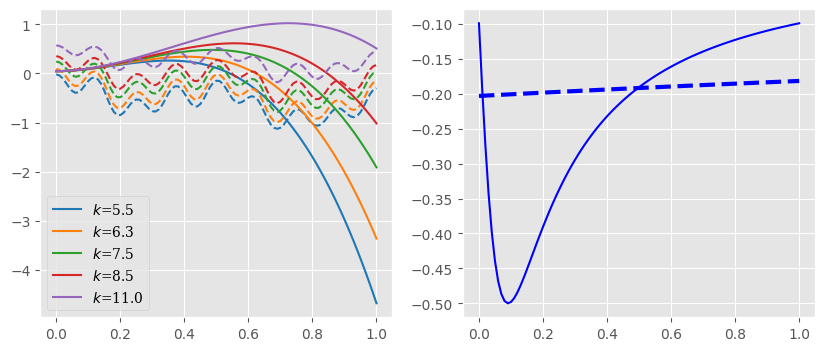

(1.0227762788018373, -4.684481175390267)

In [33]:
colors = list(plt.cm.tab10.colors)

x_lin = np.linspace(0,1,101)
x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).squeeze()

fig , (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
maxs = []
mins = []
for idx, k in enumerate(k_vals):
    g_true_arr = scaler.transform(g_true(x_lin_unscaled,k,r=0.56).reshape(-1,1)).reshape(-1)
    maxs.append(g_true_arr.max())
    mins.append(g_true_arr.min())

    ax1.plot(x_lin, g_true_arr, label=rf"$k$={k}",c=colors[idx])
    ax1.plot(x_lin, g_preds[idx],linestyle='--', c=colors[idx])

ax1.legend(prop={'family':'serif'})

f_true_arr = f_true(x_lin_unscaled)
ax2.plot(x_lin, f_true_arr,c='blue')
ax2.plot(x_lin, f_pred,linestyle="--",lw=3,c='blue')
plt.show()

max(maxs), min(mins)

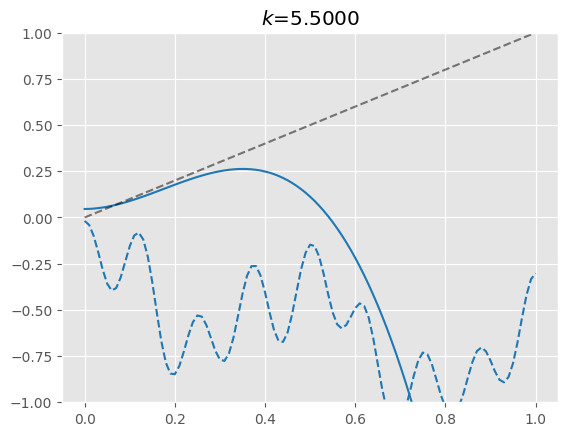

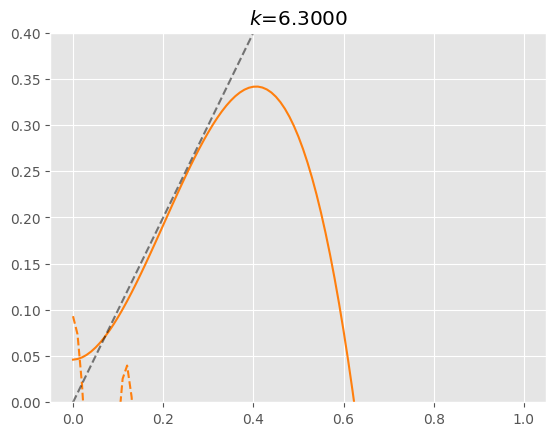

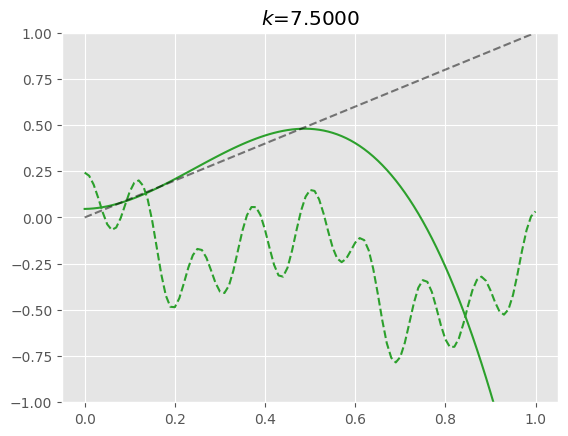

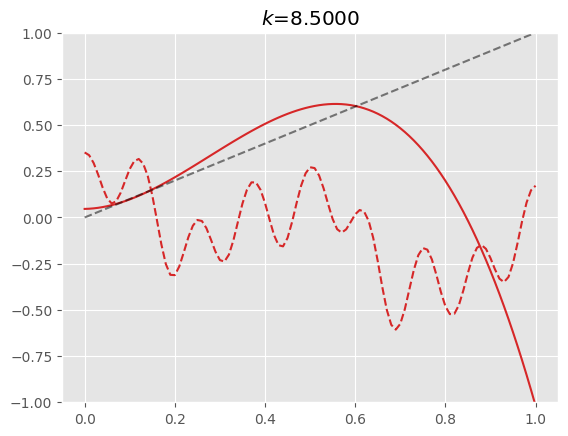

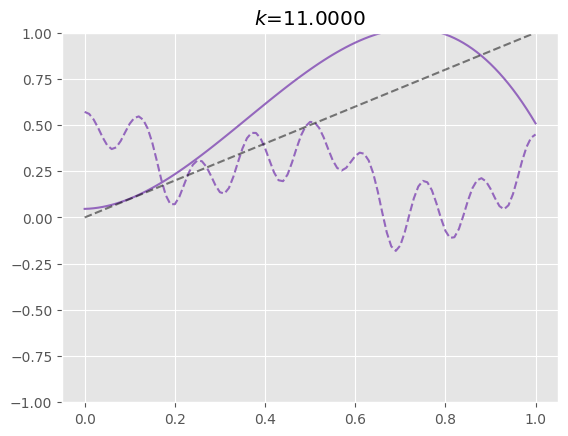

In [34]:
for idx, k in enumerate(k_vals):
    g_true_arr = scaler.transform(g_true(x_lin_unscaled,k,r=0.56).reshape(-1,1)).reshape(-1)
    plt.title(rf"$k$={k:.4f}")
    plt.plot(x_lin, g_true_arr, label=rf"$k$={k}",c=colors[idx])
    plt.plot(x_lin, g_preds[idx],linestyle='--', c=colors[idx])
    plt.plot(x_lin,x_lin, linestyle='--', c='black', alpha=0.5)
    if idx == 1:
        plt.ylim(0,0.4)
    else:
        plt.ylim(-1,1)
    plt.show()